# Simulations of color-electric flux tubes

In this notebook we perform a few simulations of color-electric flux tubes.

Change the environment variables below to switch between Numba, CUDA or python mode.

In [1]:
 # Set environment variables 
import os
#os.environ["MY_NUMBA_TARGET"] = "python" # for pure python (slow, only for debugging)
#os.environ["MY_NUMBA_TARGET"] = "numba"  # for Numba on CPUs
os.environ["MY_NUMBA_TARGET"] = "cuda"   # for NVidia GPUs
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import ashleam and other packages
import sys
sys.path.append('..')

import ashleam.core as core
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ipywidgets import *

/home/dmueller/anaconda3/envs/ashleam/lib/python3.10/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/home/dmueller/anaconda3/envs/ashleam/lib/python3.10/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/home/dmueller/anaconda3/envs/ashleam/lib/python3.10/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


Using CUDA
Using SU(2)
Using double precision


## Initial conditions

In [2]:
# electric flux tube initial conditions
def gaussian(x, y, x0, y0, sigma, a):
    return a*np.exp(-((x-x0) ** 2 + (y-y0) ** 2) / (2 * sigma ** 2))

def init_flux_tube(s, x0, y0, sigma, a, component):
    # setup color electric field
    x = np.linspace(-1.0, +1.0, s.n)
    X, Y = np.meshgrid(x, x)
    Ez = gaussian(X, Y, x0=x0, y0=y0, sigma=sigma, a=a)
    s.eta0[:, component] += Ez.flatten()
    s.eta1[:, component] += Ez.flatten()
    s.copy_to_device()
    
# plot functions
def get_energy_components(hist, t):
    eEL, eET, eBT, eBL = hist[t][0].T, hist[t][1].T, hist[t][2].T, hist[t][3].T
    return eEL, eET, eBT, eBL

## Functions for plotting

In [16]:
def plot_energy_components(hist):
    # get max time from length of hist
    t_max = len(hist)
    
    # initial plot
    fig, axs = plt.subplots(2, 2)
    e_comps = get_energy_components(hist, 0)
    e_sum = e_comps[0] + e_comps[1] + e_comps[2] + e_comps[3]
    vmin = 0.0
    vmax = np.mean(e_sum)
    
    ims = [axs[i//2, i%2].imshow(e_comps[i], origin='lower', vmin=vmin, vmax=vmax) for i in range(4)]
    for i in range(4):
        axs[i//2, i%2].axis('off')
    
    axs[0, 0].set_title('$h_{E,T}$')
    axs[0, 1].set_title('$h_{E,L}$')
    axs[1, 0].set_title('$h_{B,T}$')
    axs[1, 1].set_title('$h_{B,T}$')
    
    plt.tight_layout()
    plt.show()

    def update(t=t_max//2):
        e_comps = get_energy_components(hist, t)
        for i in range(4):
            ims[i].set_data(e_comps[i])
        fig.canvas.draw()

    interact(update, t=(0, t_max-1, 1))
    
    
def plot_energy(hist):
    # get max time from length of hist
    t_max = len(hist)
    
    E_ET, E_EL, E_BT, E_BL = [], [], [], []
    for t in range(t_max):
        e_comps = get_energy_components(hist, t)
        E_ET.append(np.sum(e_comps[0]))
        E_EL.append(np.sum(e_comps[1]))
        E_BT.append(np.sum(e_comps[2]))
        E_BL.append(np.sum(e_comps[3]))
    E_ET, E_EL, E_BT, E_BL = np.array(E_ET), np.array(E_EL), np.array(E_BT), np.array(E_BL)
    
    
    plt.clf()
    plt.plot(E_ET, label='$h_{E,T}$')
    plt.plot(E_EL, label='$h_{E,L}$')
    plt.plot(E_BT, label='$h_{B,T}$')
    plt.plot(E_BL, label='$h_{B,L}$')
    plt.plot(E_ET+E_EL+E_BT+E_BL, label='$h$ (sum)', c='black')
    plt.xlabel("$t$")
    plt.ylabel("$h(t)$")
    plt.legend()
    plt.show()
    
    
def plot_gauss_sq(gauss):
    # get max time from length of hist
    t_max = len(gauss)
    
    g_sq = []
    for t in range(t_max):
        g_sq.append(np.sum(gauss[t]))
    
    
    plt.clf()
    plt.plot(g_sq, c='black')
    plt.xlabel("$t$")
    plt.ylabel("$\\sum_x \\mathrm{Tr}(G(t,x)^2)$ ")
    plt.show()

# Single electric color flux tube (no interactions)

In [4]:
### init 
s = core.Simulation(n=512, dt=1/32)
init_flux_tube(s, x0=0.0, y0=0.0, sigma=1/16, a=0.1, component=1)

### perform time stepping

hist = []
gauss = []

t_max = int(2*s.n)
for it in tqdm(range(t_max)):
    hist.append(s.energy())
    gauss.append(s.gauss_sq())
    
    # evolve with leapfrog for a few steps
    for step in range(int(1.0/s.dt)):
        s.evolve_step()

100%|███████████████████████████████████████| 1024/1024 [00:22<00:00, 44.98it/s]


## Plot of energy density components (interactive)

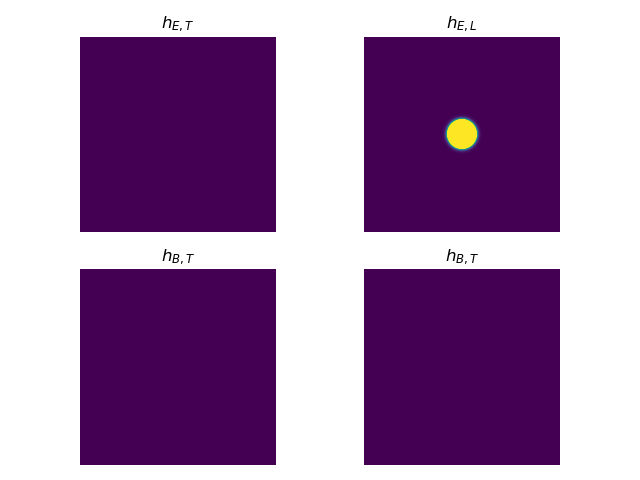

interactive(children=(IntSlider(value=512, description='t', max=1023), Output()), _dom_classes=('widget-intera…

In [17]:
%matplotlib widget
plot_energy_components(hist)

## Total energy and squared Gauss constraint

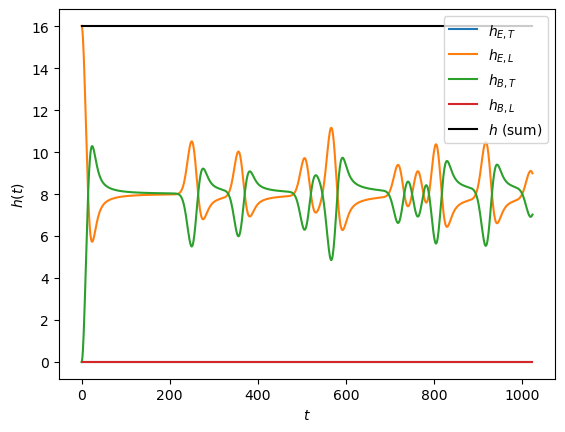

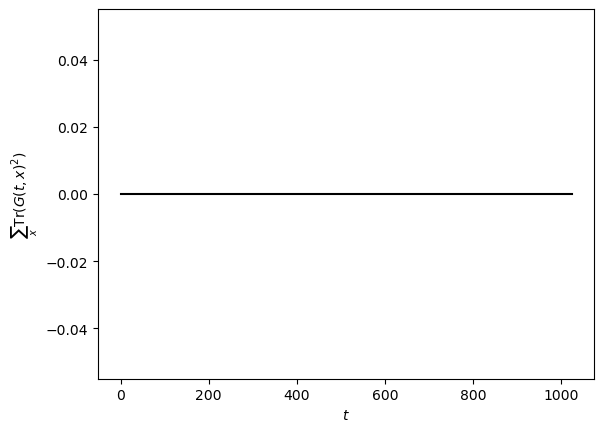

In [18]:
%matplotlib inline
plot_energy(hist)
plot_gauss_sq(gauss)

# Two flux tubes in the same color component (no interactions)

In [7]:
### init 
s = core.Simulation(n=512, dt=1/32)
d = 0.33
init_flux_tube(s, x0=+d, y0=0, sigma=1/16, a=+0.1, component=1)
init_flux_tube(s, x0=-d, y0=0, sigma=1/16, a=-0.1, component=1)

### perform time stepping
hist_noint = []
gauss_noint = []

t_max = int(2*s.n)
for it in tqdm(range(t_max)):
    hist_noint.append(s.energy())
    gauss_noint.append(s.gauss_sq())
    
    # evolve with leapfrog for a few steps
    for step in range(int(1.0/s.dt)):
        s.evolve_step()

100%|███████████████████████████████████████| 1024/1024 [00:21<00:00, 48.63it/s]


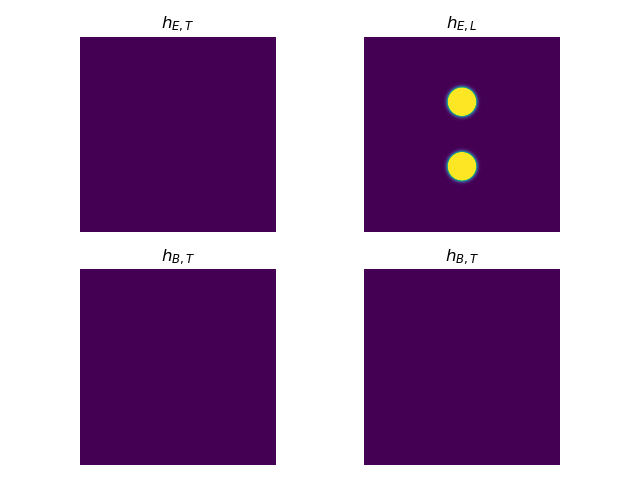

interactive(children=(IntSlider(value=512, description='t', max=1023), Output()), _dom_classes=('widget-intera…

In [19]:
%matplotlib widget
plot_energy_components(hist_noint)

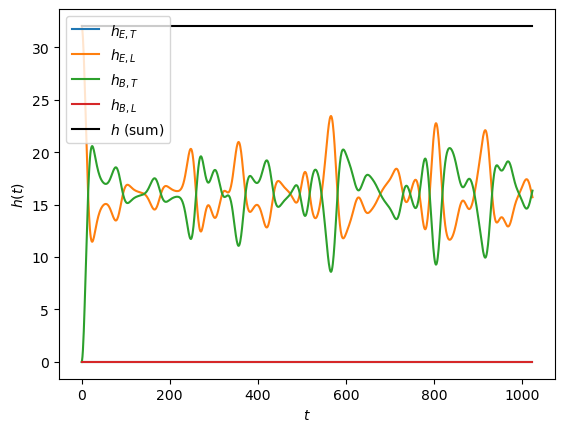

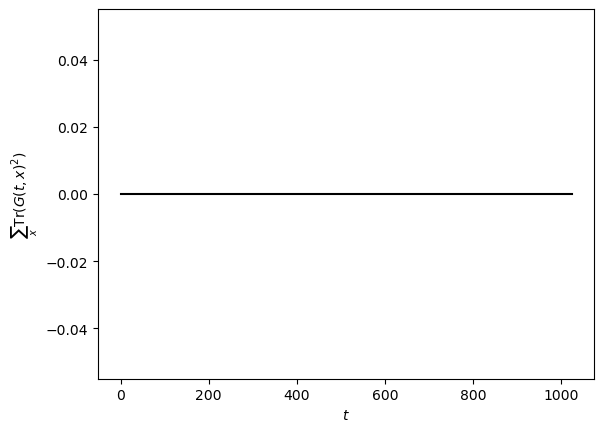

In [20]:
%matplotlib inline
plot_energy(hist_noint)
plot_gauss_sq(gauss_noint)

# Two flux tubes in two different color components (interactions)

In [10]:
### init 
s = core.Simulation(n=512, dt=1/32)
d = 0.33
init_flux_tube(s, x0=+d, y0=0, sigma=1/16, a=+0.1, component=1)
init_flux_tube(s, x0=-d, y0=0, sigma=1/16, a=-0.1, component=2)

### perform time stepping
hist_int = []
gauss_int = []

t_max = int(2*s.n)
for it in tqdm(range(t_max)):
    hist_int.append(s.energy())
    gauss_int.append(s.gauss_sq())
    
    # evolve with leapfrog for a few steps
    for step in range(int(1.0/s.dt)):
        s.evolve_step()

100%|███████████████████████████████████████| 1024/1024 [00:26<00:00, 38.60it/s]


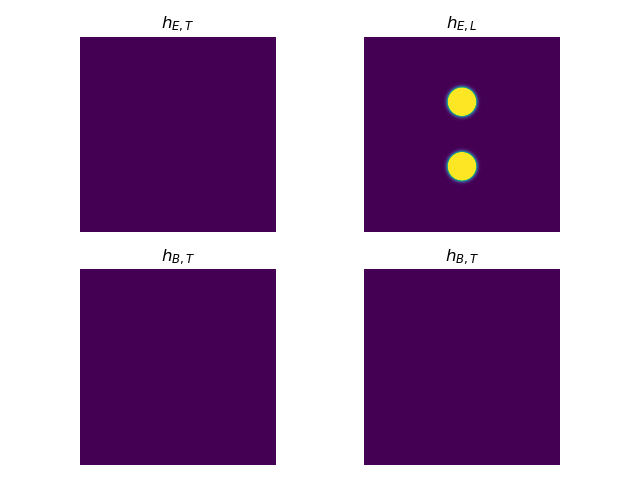

interactive(children=(IntSlider(value=512, description='t', max=1023), Output()), _dom_classes=('widget-intera…

In [21]:
%matplotlib widget
plot_energy_components(hist_int)

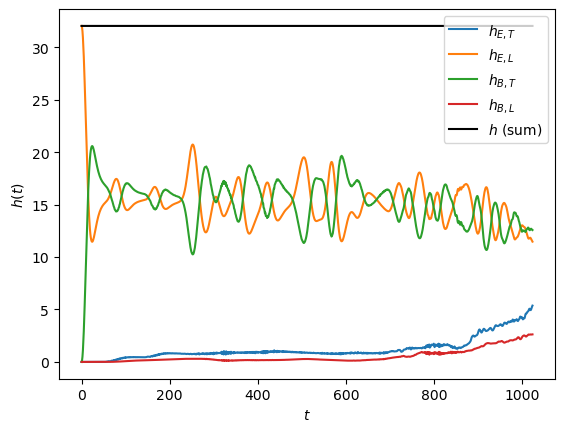

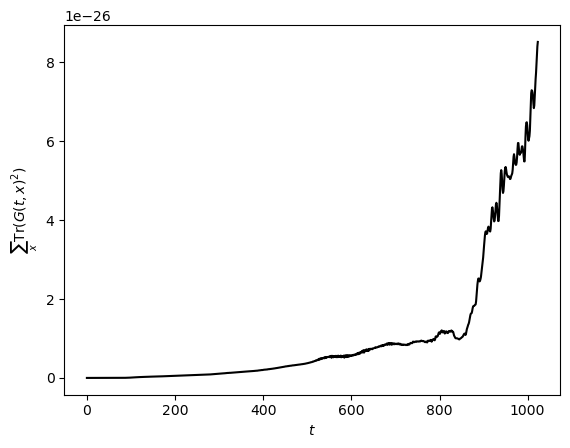

In [22]:
%matplotlib inline
plot_energy(hist_int)
plot_gauss_sq(gauss_int)